In [3]:
 # This code allows Cartopy to work with Google Colab
 # Run this code once per session, then comment it out
 !grep '^deb ' /etc/apt/sources.list | \
   sed 's/^deb /deb-src /g' | \
   tee /etc/apt/sources.list.d/deb-src.list
 !apt-get -qq update
 !apt-get -qq build-dep python3-cartopy
 !pip uninstall -y shapely
 !pip install shapely --no-binary shapely
 !pip install cartopy


deb-src http://archive.ubuntu.com/ubuntu/ jammy main restricted
deb-src http://archive.ubuntu.com/ubuntu/ jammy-updates main restricted
deb-src http://archive.ubuntu.com/ubuntu/ jammy universe
deb-src http://archive.ubuntu.com/ubuntu/ jammy-updates universe
deb-src http://archive.ubuntu.com/ubuntu/ jammy multiverse
deb-src http://archive.ubuntu.com/ubuntu/ jammy-updates multiverse
deb-src http://archive.ubuntu.com/ubuntu/ jammy-backports main restricted universe multiverse
deb-src http://security.ubuntu.com/ubuntu/ jammy-security main restricted
deb-src http://security.ubuntu.com/ubuntu/ jammy-security universe
deb-src http://security.ubuntu.com/ubuntu/ jammy-security multiverse
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Extracting templates from packages: 100%
Selecting previously unselected package gettext-base.
(Reading database ... 124561

In [4]:
# Import useful libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [85]:
# Load CSV
# Note that we're parsing the "eventDate" column as datetimes
#   and setting the "recordNumber" column as the index
wa_filepath = '/content/drive/MyDrive/OCN_215/Data_folder/wa_weather.csv'
wa_data = pd.read_csv(wa_filepath,parse_dates=['DATE'])

# View data
display(wa_data)

,STATION,NAME,DATE,PRCP,TMAX,TMIN
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-01,0.22,52,44
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-02,0.19,46,37
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-03,0.00,46,33
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-04,0.13,40,34
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-05,0.12,39,30
...,...,...,...,...,...,...
29859,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-15,0.00,47,33
29860,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-16,0.17,42,35
29861,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-17,0.02,55,36
29862,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-18,0.09,48,37


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# Divide the data by location into two Pandas DataFrames
seattle = wa_data.loc[wa_data['NAME'] == 'SEATTLE TACOMA AIRPORT, WA US']
spokane = wa_data.loc[wa_data['NAME'] == 'SPOKANE INTERNATIONAL AIRPORT, WA US']

# Make the date column the index for each DataFrame
seattle.set_index('DATE',inplace=True)
spokane.set_index('DATE',inplace=True)

# Function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

# Apply the conversion and assign to new columns in the DataFrames
seattle['seattleC'] = fahrenheit_to_celsius(seattle['TMAX'].values)  # Assign to a new column in seattle DataFrame
spokane['spokaneC'] = fahrenheit_to_celsius(spokane['TMAX'].values)  # Assign to a new column in spokane DataFrame

# Confirm that everything worked
display(seattle) # Display the updated seattle DataFrame
display(spokane) # Display the updated spokane DataFrame

<ipython-input-87-1c1963df5f2b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle['seattleC'] = fahrenheit_to_celsius(seattle['TMAX'].values)  # Assign to a new column in seattle DataFrame
<ipython-input-87-1c1963df5f2b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spokane['spokaneC'] = fahrenheit_to_celsius(spokane['TMAX'].values)  # Assign to a new column in spokane DataFrame


,STATION,NAME,PRCP,TMAX,TMIN,seattleC
DATE,,,,,,
1980-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.22,52,44,11.111111
1980-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.19,46,37,7.777778
1980-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.00,46,33,7.777778
1980-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.13,40,34,4.444444
1980-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.12,39,30,3.888889
...,...,...,...,...,...,...
2020-11-15,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.20,53,46,11.666667
2020-11-16,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.49,51,46,10.555556
2020-11-17,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.53,63,47,17.222222


,STATION,NAME,PRCP,TMAX,TMIN,spokaneC
DATE,,,,,,
1980-01-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.11,37,33,2.777778
1980-01-02,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.07,39,30,3.888889
1980-01-03,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.00,35,24,1.666667
1980-01-04,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.26,30,23,-1.111111
1980-01-05,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.12,30,6,-1.111111
...,...,...,...,...,...,...
2020-11-15,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.00,47,33,8.333333
2020-11-16,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.17,42,35,5.555556
2020-11-17,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",0.02,55,36,12.777778


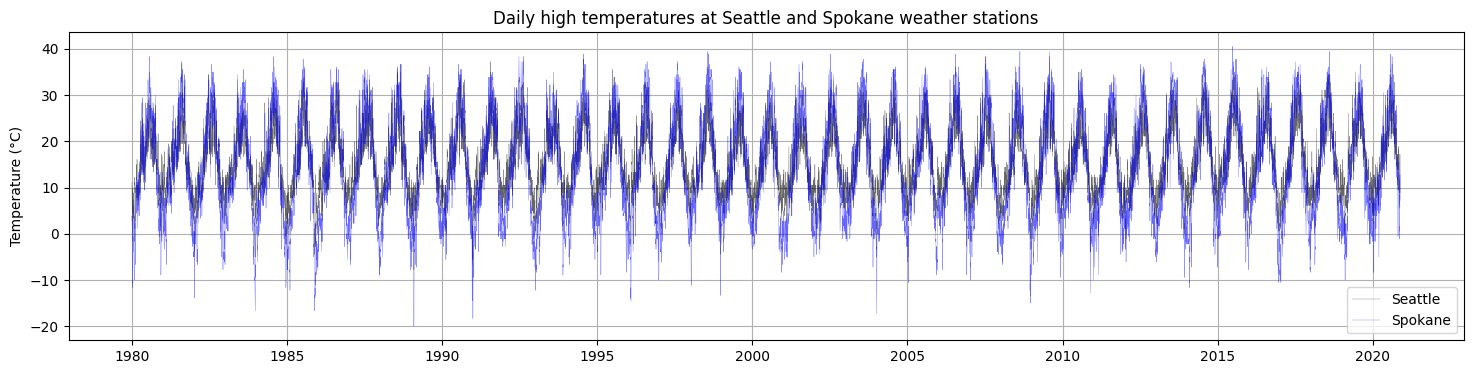

In [88]:
# Plot of the high temperature data
plt.figure(figsize=(18,4))
plt.plot(seattle['seattleC'].index.values,seattle['seattleC'].values,c='k',lw=0.25,alpha=0.6,label='Seattle')
plt.plot(spokane['spokaneC'].index.values,spokane['spokaneC'].values,c='b',lw=0.25,alpha=0.6,label='Spokane')
plt.grid()
plt.legend()
plt.ylabel('Temperature (°C)')
plt.title('Daily high temperatures at Seattle and Spokane weather stations');

In [44]:
# This finds the year for each date
seattle.index.year

Index([1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
       ...
       2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
      dtype='int32', name='DATE', length=14934)

In [46]:
# This finds the day-of-year for each date
seattle.index.dayofyear

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       315, 316, 317, 318, 319, 320, 321, 322, 323, 324],
      dtype='int32', name='DATE', length=14934)

In [90]:
# We can group the data by day-of-year, then calculate the average over each day-of-year, for each column
#
# This type of average is called a "climatology"
# Select only numerical columns for calculating the mean
seattle_clim = seattle.select_dtypes(include=np.number).groupby(seattle.index.dayofyear).mean()
spokane_clim = spokane.select_dtypes(include=np.number).groupby(spokane.index.dayofyear).mean()

# Function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

# Apply the conversion to the 'TMAX' column
seattle_clim['TMAX'] = fahrenheit_to_celsius(seattle_clim['TMAX'])
spokane_clim['TMAX'] = fahrenheit_to_celsius(spokane_clim['TMAX'])

#If you have a 'TMIN' column and want to convert it as well:
seattle_clim['TMIN'] = fahrenheit_to_celsius(seattle_clim['TMIN'])
spokane_clim['TMIN'] = fahrenheit_to_celsius(spokane_clim['TMIN'])


# See result
display(seattle_clim)
display(spokane_clim)

,PRCP,TMAX,TMIN,seattleC
DATE,,,,
1,0.170000,7.710027,2.317073,7.710027
2,0.225122,7.520325,1.978320,7.520325
3,0.143415,7.886179,2.181572,7.886179
4,0.203171,7.764228,2.168022,7.764228
5,0.211463,7.262873,2.059621,7.262873
...,...,...,...,...
362,0.126750,7.458333,2.180556,7.458333
363,0.188750,6.958333,1.847222,6.958333
364,0.173000,7.416667,1.819444,7.416667


,PRCP,TMAX,TMIN,spokaneC
DATE,,,,
1,0.070000,-0.487805,-5.663957,-4.878049e-01
2,0.055122,0.000000,-6.368564,-4.332578e-17
3,0.057561,0.230352,-6.151762,2.303523e-01
4,0.073171,0.799458,-5.907859,7.994580e-01
5,0.040244,0.325203,-6.382114,3.252033e-01
...,...,...,...,...
362,0.071500,-0.305556,-5.555556,-3.055556e-01
363,0.085500,-0.583333,-6.611111,-5.833333e-01
364,0.093750,-0.888889,-6.527778,-8.888889e-01


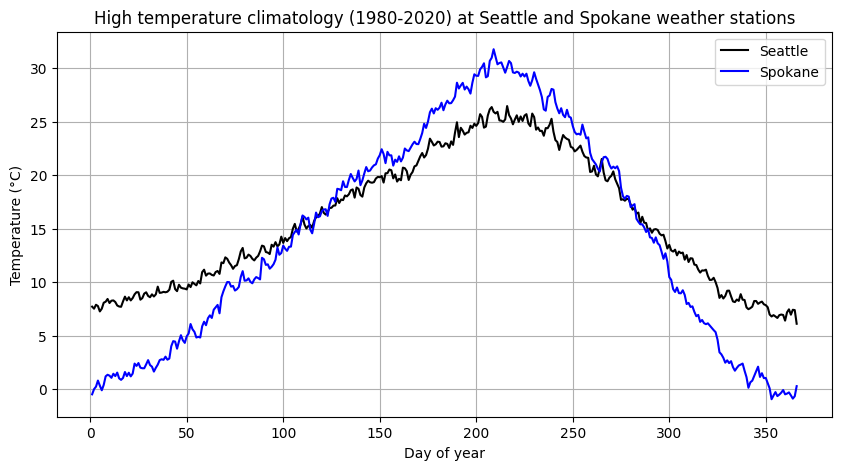

In [91]:
# Plot of climatologies
plt.figure(figsize=(10,5))
plt.plot(seattle_clim.index,seattle_clim['TMAX'].values,c='k',label='Seattle')
plt.plot(spokane_clim.index,spokane_clim['TMAX'].values,c='b',label='Spokane')
plt.grid()
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Temperature (°C)')
plt.title('High temperature climatology (1980-2020) at Seattle and Spokane weather stations');

In [92]:
# We can group the data by year, then calculate the annual averages for each column
# Select only numerical columns for calculating the mean
seattle_ann = seattle.select_dtypes(include=np.number).groupby(seattle.index.year).mean()
spokane_ann = spokane.select_dtypes(include=np.number).groupby(spokane.index.year).mean()

# Function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

# Apply the conversion to the 'TMAX' column in seattle_ann
seattle_ann['TMAX'] = fahrenheit_to_celsius(seattle_ann['TMAX'])
spokane_ann['TMAX'] = fahrenheit_to_celsius(spokane_ann['TMAX'])

# Apply the conversion to the 'TMAX' column in seattle_ann
seattle_ann['TMIN'] = fahrenheit_to_celsius(seattle_ann['TMIN'])
spokane_ann['TMIN'] = fahrenheit_to_celsius(spokane_ann['TMIN'])

# See result
display(seattle_ann)
display(spokane_ann)

,PRCP,TMAX,TMIN,seattleC
DATE,,,,
1980,0.097268,14.649362,6.841226,14.649362
1981,0.096986,15.561644,7.382040,15.561644
1982,0.107726,14.841705,6.654490,14.841705
1983,0.112137,15.313546,7.680365,15.313546
1984,0.101066,14.799636,6.854888,14.799636
1985,0.068849,14.237443,5.707763,14.237443
1986,0.105041,15.805175,7.426180,15.805175
1987,0.082000,16.745814,7.301370,16.745814
1988,0.090109,15.695203,6.982392,15.695203


,PRCP,TMAX,TMIN,spokaneC
DATE,,,,
1980,0.046530,13.811475,3.210383,13.811475
1981,0.040849,14.447489,3.210046,14.447489
1982,0.047260,13.943683,2.824962,13.943683
1983,0.062027,14.573820,3.814307,14.573820
1984,0.049208,13.439587,2.436248,13.439587
1985,0.030712,12.350076,0.814307,12.350076
1986,0.042603,14.380518,3.153729,14.380518
1987,0.048438,15.418569,3.286149,15.418569
1988,0.045137,14.807225,3.076806,14.807225


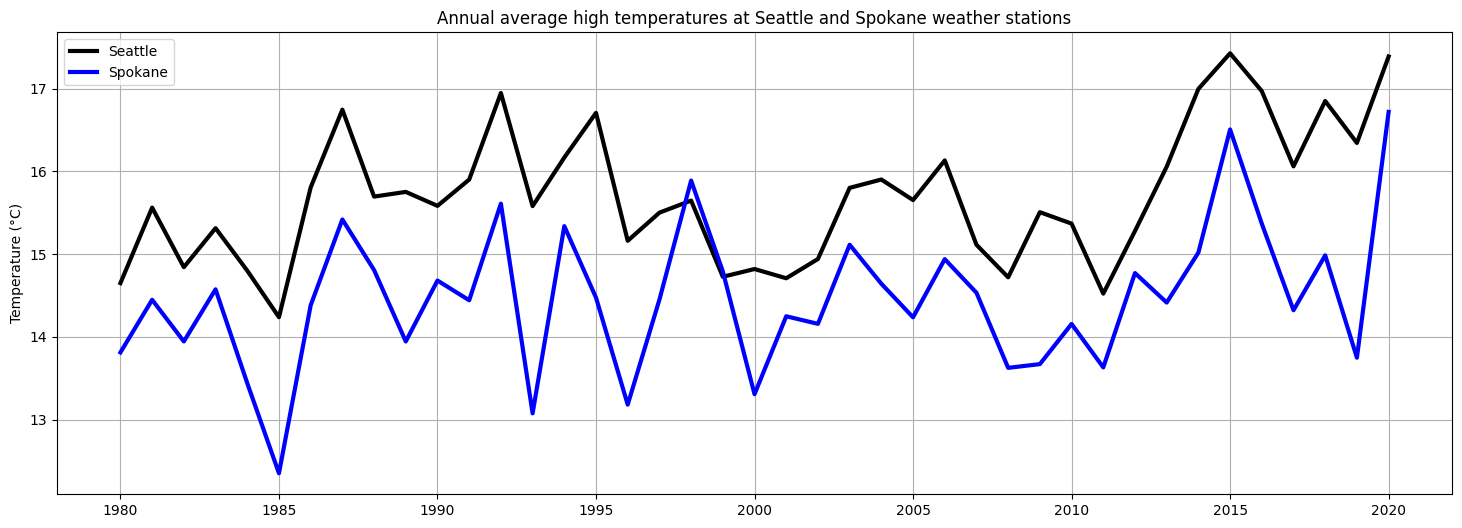

In [93]:
# Plot of the annual average high temperature data
plt.figure(figsize=(18,6))
plt.plot(seattle_ann['TMAX'].index.values,seattle_ann['TMAX'].values,c='k',lw=3,label='Seattle')
plt.plot(spokane_ann['TMAX'].index.values,spokane_ann['TMAX'].values,c='b',lw=3,label='Spokane')
plt.grid()
plt.legend()
plt.ylabel('Temperature (°C)')
plt.title('Annual average high temperatures at Seattle and Spokane weather stations');

In [94]:
# Correlate annual average high temperatures from Seattle and Spokane
#
# Note that we provide the entire Pandas Series, not just the .values or the .index
r = seattle_ann['TMAX'].corr(spokane_ann['TMAX'])
print('The r^2 value is:',r**2)

The r^2 value is: 0.5435287424617927


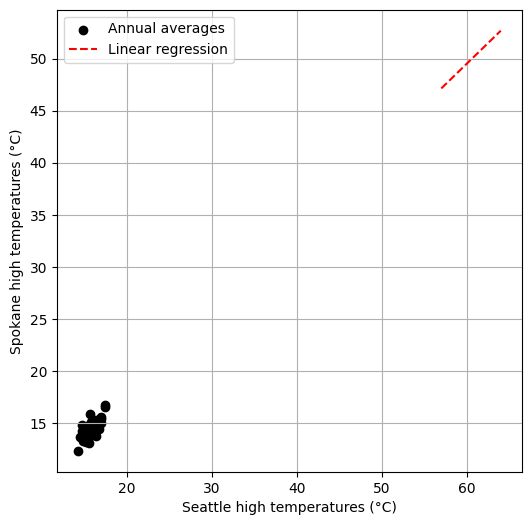

In [95]:
# In other words, there's clearly a relationship between annual-average temperatures in Seattle
# and Spokane.
#
# This plot shows that close relationship, and also shows the regression line.
#
# The r^2 value tells us that 50% of the variance of annual-average temperatures in Spokane
# can be explained by the annual-average Seattle temperatures.

# Linear regression using SciPy (see Lesson #14 for details)
slope,intercept,_,_,_ = stats.linregress(seattle_ann['TMAX'].values,spokane_ann['TMAX'].values)

#change to degree C

# Make plot
plt.figure(figsize=(6,6))
plt.scatter(seattle_ann['TMAX'],spokane_ann['TMAX'],c='k',label='Annual averages')
plt.plot(np.arange(57,65), slope * np.arange(57,65) + intercept,c='r',ls='--',label='Linear regression')
plt.legend()
plt.grid()
plt.xlabel('Seattle high temperatures (°C)')
plt.ylabel('Spokane high temperatures (°C)');

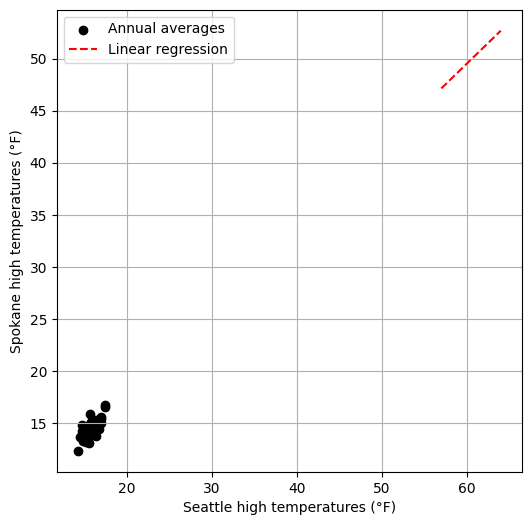

In [96]:
# In other words, there's clearly a relationship between annual-average temperatures in Seattle
# and Spokane.
#
# This plot shows that close relationship, and also shows the regression line.
#
# The r^2 value tells us that 50% of the variance of annual-average temperatures in Spokane
# can be explained by the annual-average Seattle temperatures.

# Linear regression using SciPy (see Lesson #14 for details)
slope,intercept,_,_,_ = stats.linregress(seattle_ann['TMAX'].values,spokane_ann['TMAX'].values)

# Make plot
plt.figure(figsize=(6,6))
plt.scatter(seattle_ann['TMAX'],spokane_ann['TMAX'],c='k',label='Annual averages')
plt.plot(np.arange(57,65), slope * np.arange(57,65) + intercept,c='r',ls='--',label='Linear regression')
plt.legend()
plt.grid()
plt.xlabel('Seattle high temperatures (°F)')
plt.ylabel('Spokane high temperatures (°F)');

In [100]:
# Function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

# Calculate annual averages using .resample() instead of .groupby()
seattle['TMAX'].resample('YS').mean()
spokane['TMAX'].resample('YS').mean()

# Apply the conversion to the 'TMAX' column in seattle_ann
seattle['TMAX'] = fahrenheit_to_celsius(seattle['TMAX'])
spokane['TMAX'] = fahrenheit_to_celsius(spokane['TMAX'])

# Apply the conversion to the 'TMAX' column in seattle_ann
#seattle['TMIN'] = fahrenheit_to_celsius(seattle['TMIN'])
#spokane['TMIN'] = fahrenheit_to_celsius(spokane['TMIN'])



<ipython-input-100-301fb2d5b6dc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle['TMAX'] = fahrenheit_to_celsius(seattle['TMAX'])
<ipython-input-100-301fb2d5b6dc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spokane['TMAX'] = fahrenheit_to_celsius(spokane['TMAX'])


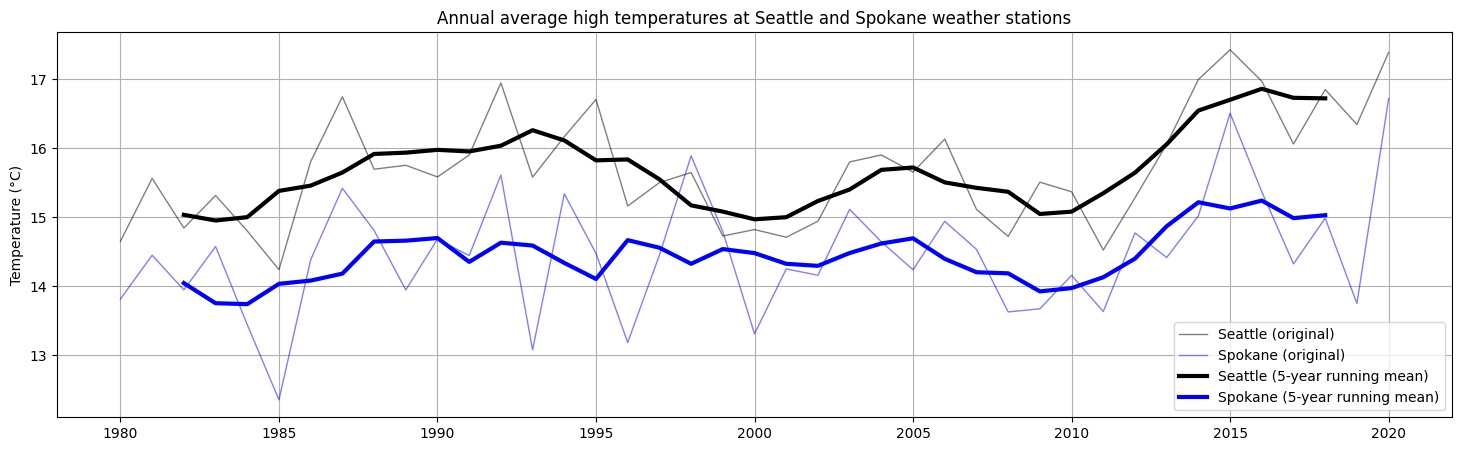

In [103]:
# Smooth annual average temperatures using a 5-year running mean
seattle_ann_rm = seattle_ann['TMAX'].rolling(window=5,center=True).mean()
spokane_ann_rm = spokane_ann['TMAX'].rolling(window=5,center=True).mean()

# Apply the conversion to the running mean Series directly
# No need to convert here as the data is already in Celsius


# Plot
plt.figure(figsize=(18,5))
plt.plot(seattle_ann['TMAX'].index.values,seattle_ann['TMAX'].values,c='k',lw=1,alpha=0.5,label='Seattle (original)')
plt.plot(spokane_ann['TMAX'].index.values,spokane_ann['TMAX'].values,c='b',lw=1,alpha=0.5,label='Spokane (original)')
plt.plot(seattle_ann_rm.index, seattle_ann_rm.values, c='k',lw=3,label='Seattle (5-year running mean)') # Access values using .values
plt.plot(spokane_ann_rm.index, spokane_ann_rm.values, c='b',lw=3,label='Spokane (5-year running mean)') # Access values using .values
plt.grid()
plt.legend()
plt.ylabel('Temperature (°C)') # Update y-axis label
plt.title('Annual average high temperatures at Seattle and Spokane weather stations');

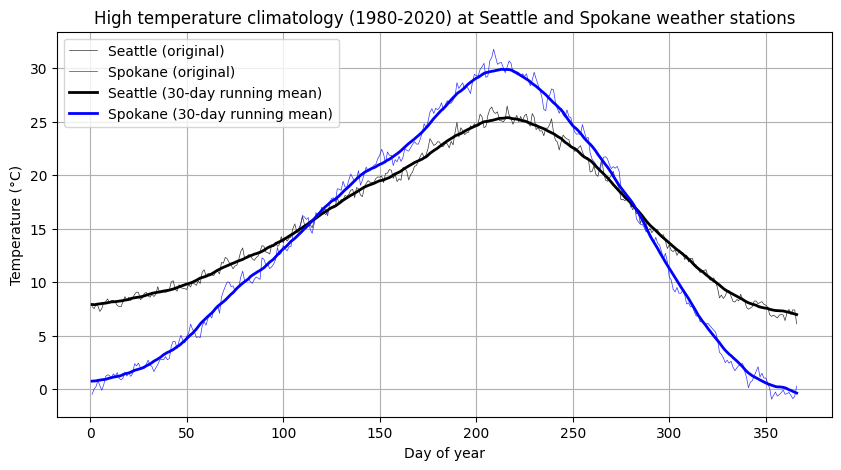

In [105]:
# Smooth high temperature climatologies using a 30-day running mean
seattle_clim_rm = seattle_clim['TMAX'].rolling(window=30,center=True,min_periods=1).mean()
spokane_clim_rm = spokane_clim['TMAX'].rolling(window=30,center=True,min_periods=1).mean()

# Plot of climatologies
plt.figure(figsize=(10,5))
plt.plot(seattle_clim.index,seattle_clim['TMAX'].values,c='k',lw=0.5,alpha=0.8,label='Seattle (original)')
plt.plot(spokane_clim.index,spokane_clim['TMAX'].values,c='b',lw=0.5,alpha=0.8,label='Spokane (original)')
plt.plot(seattle_clim_rm,c='k',lw=2,label='Seattle (30-day running mean)')
plt.plot(spokane_clim_rm,c='b',lw=2,label='Spokane (30-day running mean)')
plt.grid()
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Temperature (°C)')  # Changed to °C
plt.title('High temperature climatology (1980-2020) at Seattle and Spokane weather stations');